In [251]:
import pandas as pd

In [252]:
df_price = pd.read_csv('merged_daily_new.csv')

In [253]:
df_price

,Price,Date
0,47.803208,2010.07.21
1,58.061250,2010.07.22
2,46.146042,2010.07.23
3,43.593292,2010.07.24
4,19.148125,2010.07.25
...,...,...
2715,30.209583,27.12.2017
2716,33.220417,28.12.2017
2717,23.760000,29.12.2017
2718,24.729167,30.12.2017


In [254]:
#df_price.set_index('Date',inplace=True)
#df_price.head()

In [255]:
df_price['Date']

0       2010.07.21
1       2010.07.22
2       2010.07.23
3       2010.07.24
4       2010.07.25
           ...    
2715    27.12.2017
2716    28.12.2017
2717    29.12.2017
2718    30.12.2017
2719    31.12.2017
Name: Date, Length: 2720, dtype: object

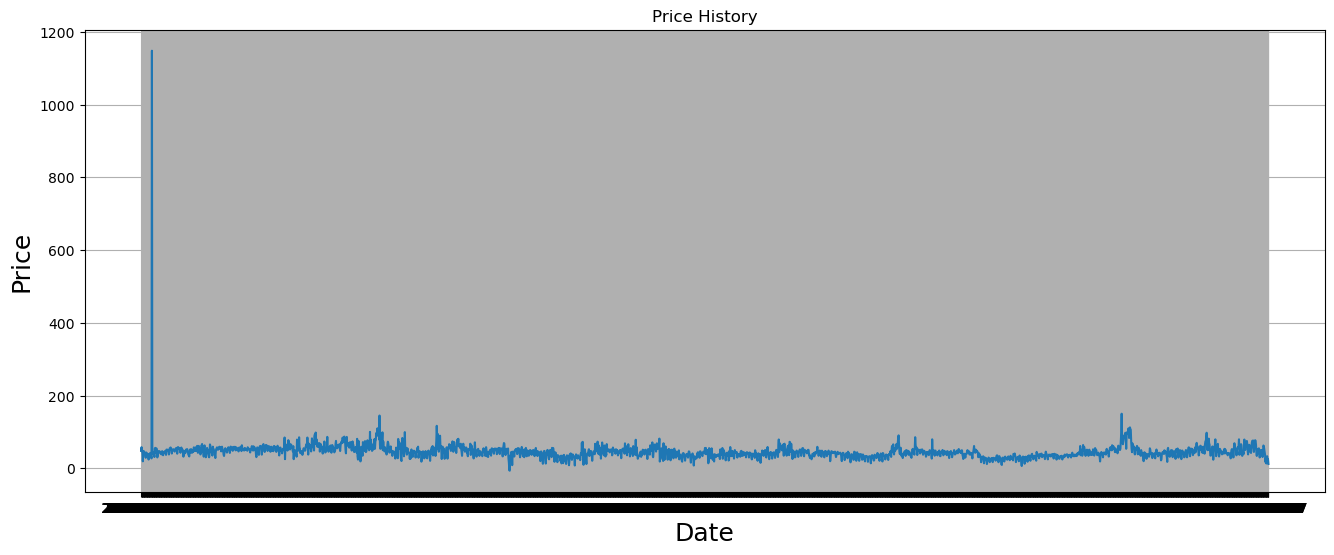

In [256]:
import matplotlib.pyplot as plt

# Assuming 'df_price' is your DataFrame and 'Date' and 'Price' are the columns
plt.figure(figsize=(16,6))
plt.title('Price History')
plt.plot(df_price['Date'], df_price['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.grid(True)
plt.show()


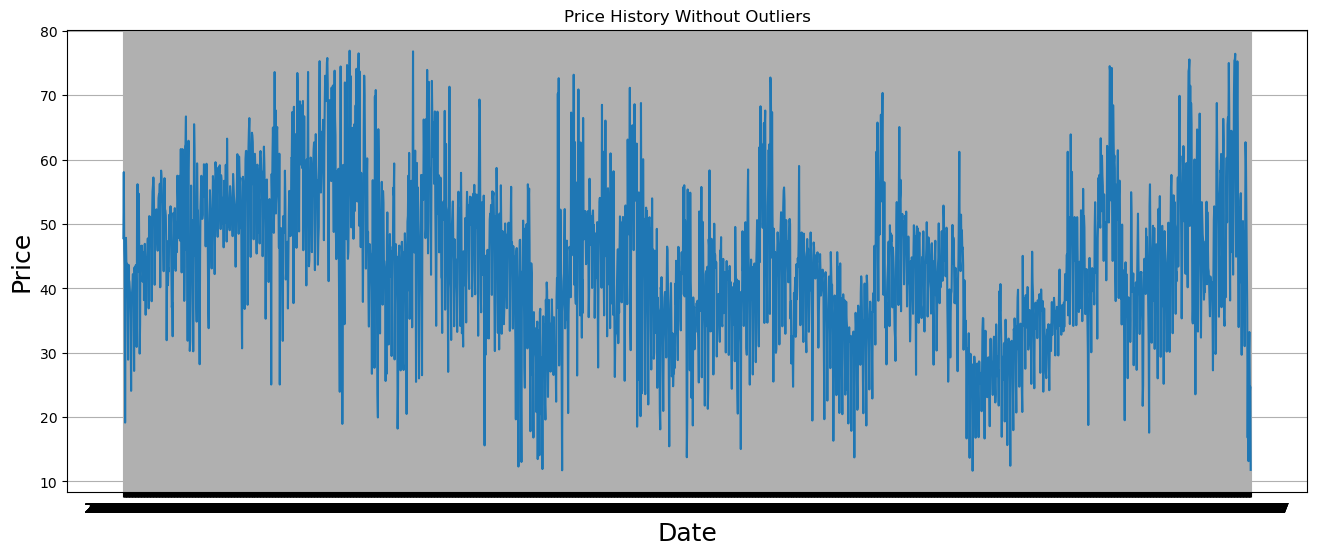

In [257]:
# Calculate the IQR for the 'Price' column
Q1 = df_price['Price'].quantile(0.25)
Q3 = df_price['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define the acceptable range (1.5 times the IQR is a common choice)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the 'Price' column
df_price_cleaned = df_price[(df_price['Price'] >= lower_bound) & (df_price['Price'] <= upper_bound)]

# Plot the cleaned data to verify
plt.figure(figsize=(16,6))
plt.title('Price History Without Outliers')
plt.plot(df_price_cleaned['Date'], df_price_cleaned['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.grid(True)
plt.show()

In [258]:
df_price_cleaned

,Price,Date
0,47.803208,2010.07.21
1,58.061250,2010.07.22
2,46.146042,2010.07.23
3,43.593292,2010.07.24
4,19.148125,2010.07.25
...,...,...
2715,30.209583,27.12.2017
2716,33.220417,28.12.2017
2717,23.760000,29.12.2017
2718,24.729167,30.12.2017


In [259]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt


# Normalize the 'Price' column using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_price_cleaned['Price_scaled'] = scaler.fit_transform(df_price_cleaned[['Price']])

# Prepare the data for time-series forecasting
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Define sequence length (e.g., we use the past 60 days to predict the next day)
SEQ_LENGTH = 30

# Create sequences
price_data = df_price_cleaned['Price_scaled'].values
X, y = create_sequences(price_data, SEQ_LENGTH)

# Split the data into training and testing sets
split_ratio = 0.95  # Use 95% of data for training
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape input to be 3D [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


C:\Users\sunde\AppData\Local\Temp\ipykernel_19908\3884765409.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_cleaned['Price_scaled'] = scaler.fit_transform(df_price_cleaned[['Price']])


In [260]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define a more complex LSTM model with dropout to prevent overfitting
model = Sequential()

# Input layer with more units and a Dropout layer to reduce overfitting
model.add(Input(shape=(30, 1))) 
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=56, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=20))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0530 - val_loss: 0.0324
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0202 - val_loss: 0.0323
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0217 - val_loss: 0.0324
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0192 - val_loss: 0.0330
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0210 - val_loss: 0.0313
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0191 - val_loss: 0.0314
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0186 - val_loss: 0.0319
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0199 - val_loss: 0.0332
Epoch 9/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0187 - val_loss: 0.0314
Epoch 10/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0196 - val_loss: 0.0305
Epoch 11/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0184 - val_loss: 0.0304
Epoch 12/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

In [261]:
'''# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(Input(shape=(60, 1))) 
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))'''

"# Build the LSTM model\nmodel = Sequential()\n\n# Add LSTM layers\nmodel.add(Input(shape=(60, 1))) \nmodel.add(LSTM(units=50, return_sequences=True))\nmodel.add(LSTM(units=50))\nmodel.add(Dense(units=1))  # Output layer\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='mean_squared_error')\n\n# Train the model\nhistory = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

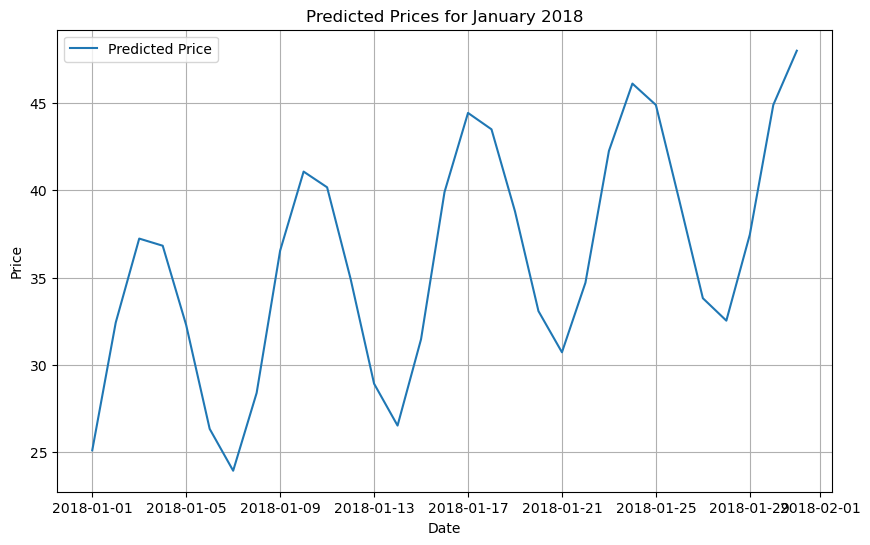

         Date  Predicted_Price
0  2018-01-01        25.086639
1  2018-01-02        32.416874
2  2018-01-03        37.233116
3  2018-01-04        36.822983
4  2018-01-05        32.268707
5  2018-01-06        26.317310
6  2018-01-07        23.916491
7  2018-01-08        28.380369
8  2018-01-09        36.541000
9  2018-01-10        41.075352
10 2018-01-11        40.174305
11 2018-01-12        34.925079
12 2018-01-13        28.910923
13 2018-01-14        26.506208
14 2018-01-15        31.459938
15 2018-01-16        39.904579
16 2018-01-17        44.441700
17 2018-01-18        43.500778
18 2018-01-19        38.796253
19 2018-01-20        33.072231
20 2018-01-21        30.709963
21 2018-01-22        34.701275
22 2018-01-23        42.261402
23 2018-01-24        46.124275
24 2018-01-25        44.897724
25 2018-01-26        39.404278
26 2018-01-27        33.812740
27 2018-01-28        32.525726
28 2018-01-29        37.463017
29 2018-01-30        44.903732
30 2018-01-31        48.009708


In [262]:
# Predicting for the next 31 days (January 2018)
predicted_prices = []
last_sequence = price_data[-SEQ_LENGTH:]  # Take the last 60 days of data

for _ in range(31):  # Predict for 31 days
    last_sequence = np.reshape(last_sequence, (1, SEQ_LENGTH, 1))
    next_price_scaled = model.predict(last_sequence)
    predicted_prices.append(next_price_scaled[0, 0])
    last_sequence = np.append(last_sequence[0, 1:], next_price_scaled)  # Update the sequence

# Inverse transform the predicted prices to get the actual values
predicted_prices_actual = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Create a date range for the predictions
predicted_dates = pd.date_range(start='2018-01-01', periods=31)

# Create a DataFrame with the predicted prices
predicted_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Price': predicted_prices_actual.flatten()})

# Plot the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(predicted_df['Date'], predicted_df['Predicted_Price'], label='Predicted Price')
plt.title('Predicted Prices for January 2018')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the predicted DataFrame
print(predicted_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

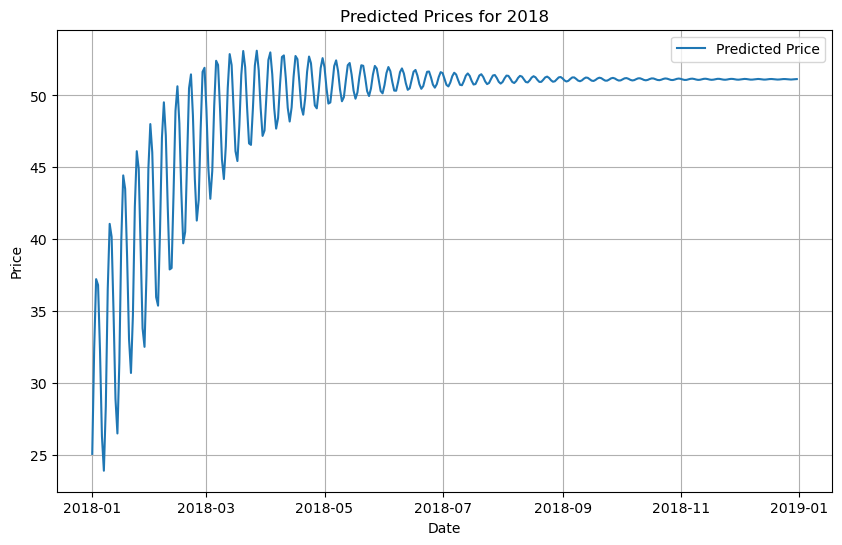

          Date  Predicted_Price
0   2018-01-01        25.086639
1   2018-01-02        32.416874
2   2018-01-03        37.233116
3   2018-01-04        36.822983
4   2018-01-05        32.268707
..         ...              ...
360 2018-12-27        51.110573
361 2018-12-28        51.104656
362 2018-12-29        51.112022
363 2018-12-30        51.126442
364 2018-12-31        51.136444

[365 rows x 2 columns]


In [263]:
# Predicting for the next 365 days (entire year 2018)
predicted_prices = []
last_sequence = price_data[-SEQ_LENGTH:]  # Take the last 60 days of data

for _ in range(365):  # Predict for 365 days
    last_sequence = np.reshape(last_sequence, (1, SEQ_LENGTH, 1))
    next_price_scaled = model.predict(last_sequence)
    predicted_prices.append(next_price_scaled[0, 0])
    last_sequence = np.append(last_sequence[0, 1:], next_price_scaled)  # Update the sequence

# Inverse transform the predicted prices to get the actual values
predicted_prices_actual = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Create a date range for the predictions
predicted_dates = pd.date_range(start='2018-01-01', periods=365)

# Create a DataFrame with the predicted prices
predicted_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Price': predicted_prices_actual.flatten()})

# Plot the predicted prices for 2018
plt.figure(figsize=(10, 6))
plt.plot(predicted_df['Date'], predicted_df['Predicted_Price'], label='Predicted Price')
plt.title('Predicted Prices for 2018')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('Prediction_1.jpg')
plt.show()


# Print the predicted DataFrame
print(predicted_df)
